In [1]:
import sys, os, itertools, sklearn
sys.path.append('/home/roquero/CausalAggregation/Code')
import pandas as pd
import numpy as np
import _pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn.linear_model import LassoCV, Lasso
from sklearn import datasets
from sklearn.metrics import auc
from scipy.interpolate import UnivariateSpline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%reload_ext autoreload
%autoreload 2
np.set_printoptions(suppress=True)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)}, linewidth=100000)
from backfitting import Backfitting
from boosting import Boosting
from base_environment import BaseEnvironment
from collection_environment import CollectionEnvironment
from regression_method import PolynomialRegression, RandomForestRegression
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures


/home/roquero/miniconda3/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
ik_h, se_h = [], (lambda input_samples:input_samples)
ik_x1, se_x1 = ['h'], (lambda input_samples: 2*input_samples[0] + input_samples[1])
ik_x2, se_x2 = ['h', 'x1'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x3, se_x3 = ['x1', 'x2'], (lambda input_samples: -input_samples[0] * 2*input_samples[1] + input_samples[2])
#ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: input_samples[0] + input_samples[1] + input_samples[2])
ik_x4, se_x4 = ['x1', 'x3'], (lambda input_samples: np.log(1+np.abs(input_samples[0])) + input_samples[1] + input_samples[2])
ik_y, se_y = ['h','x1','x2','x3','x4'], (lambda input_samples:
                                         input_samples[0] 
                                         + input_samples[1]**2
                                         + 0.5*input_samples[1]*input_samples[2]*input_samples[3]
                                         - 0.5*input_samples[3]*input_samples[4]
                                         - input_samples[2]*input_samples[4] + input_samples[5])
ik_x5, se_x5 = ['x2', 'x4', 'y'], (lambda input_samples: 2*input_samples[0] + input_samples[1] - input_samples[2] + input_samples[3])

In [3]:
fh = {'input_keys':ik_h, 'structural_eq': se_h}
f1 = {'input_keys':ik_x1, 'structural_eq': se_x1}
f2 = {'input_keys':ik_x2, 'structural_eq': se_x2}
f3 = {'input_keys':ik_x3, 'structural_eq': se_x3}
f4 = {'input_keys':ik_x4, 'structural_eq': se_x4}
f5 = {'input_keys':ik_x5, 'structural_eq': se_x5}
fy = {'input_keys':ik_y, 'structural_eq': se_y}

sh = lambda n_samples: np.random.normal(size=n_samples)
s1 = lambda n_samples: np.random.normal(size=n_samples)
s2 = lambda n_samples: np.random.normal(size=n_samples)
s3 = lambda n_samples: np.random.normal(size=n_samples)
s4 = lambda n_samples: np.random.normal(size=n_samples)
s5 = lambda n_samples: np.random.normal(size=n_samples)
sy = lambda n_samples: np.random.normal(size=n_samples)

topo_order = ['h','x1','x2','x3','x4','y','x5']
y_key = 'y'
x_key = ['x1','x2','x3','x4','x5']

structural_equation_dict = {'x1':f1, 'x2':f2, 'x3':f3, 'y':fy, 'x4':f4, 'x5':f5, 'h':fh}
disturbance_sampler_dict = {'x1':s1, 'x2':s2, 'x3':s3, 'y':sy, 'x4':s4, 'x5':s5, 'h':sh}

base = BaseEnvironment(structural_equation_dict, disturbance_sampler_dict, topo_order, y_key, x_key)
coll_env = CollectionEnvironment(base)

In [4]:
coll_env.add_env('e1', {'x1':{'type':'independent'},'x2':{'type':'independent'}, 'x3':{'type':'independent'}}, 10000)
coll_env.add_env('e2', {'x2':{'type':'independent'},'x4':{'type':'independent'}}, 10000)
coll_env.add_env('e3', {'x3':{'type':'independent'},'x4':{'type':'independent'}}, 10000)
coll_env.add_env('e4', {'x1':{'type':'independent'},'x5':{'type':'independent'}}, 10000)
#coll_env.add_env('e5', {'x4':{'type':'independent'}}, 100000)

In [5]:
params_method = {'regression_method':'HuberRegressor',
                 'power_features': {
                     'e1':3,
                     'e2':2,
                     'e3':2,
                     'e4':2,
                     'e5':2,
                                     },
                 'include_bias':{
                     'e1':True,
                     'e2':False,
                     'e3':False,
                     'e4':False,
                     'e5':False,
                                     },
                 'interactions_env': {
                     'e1':'full',
                     'e2':'int',
                     'e3':'int',
                     'e4':'int',
                     'e5':'full',
                                     },
                 'n_estimators':3
                }

backfit = Backfitting(PolynomialRegression, 'backfitting', max_n_iter=20, gap_convergence=1e-5, params_method = params_method)
                      
                      #{'power_features':2, 'include_bias':False})


res = backfit.fit(coll_env)

100%|██████████| 20/20 [00:18<00:00,  1.08it/s]


In [6]:
backfit.output_model_variation

{'e1': [540.6913030655243,
  11.05532561706411,
  19.560678852394705,
  2.489866766881125,
  0.018454097631234186,
  0.7434395331476545,
  0.9039601968649164,
  0.3385331956025475,
  0.033986002150878825,
  0.011829855543568791,
  0.09359776096575761,
  0.0051722643469532216,
  0.00470665255974166,
  0.004688137451515884,
  6.525983589782574e-05,
  0.004761021062468162,
  0.004676310230948856,
  2.20235032128949e-05,
  0.00022385638295646087],
 'e2': [10.089953549499652,
  2.016272582766271,
  0.1998656049569829,
  0.30947539058156665,
  0.11992972101421678,
  0.15394651134325235,
  0.19843288747732696,
  0.12432212309227832,
  0.12540798268632017,
  0.14015502400381888,
  0.09411381388157218,
  0.09308555738023865,
  0.09240946086769103,
  0.09323304198406664,
  0.09319434474399681,
  0.13923069437927676,
  0.09356073371978557,
  0.13921708691605736,
  0.09341586874268842],
 'e3': [24.799173838330024,
  11.316286140556619,
  0.4750046304766111,
  0.0,
  0.012889064982421965,
  0.49921

In [7]:
samples = np.random.normal(size=(6,10))
samples

array([[-0.230, 0.540, -0.440, -1.510, -0.745, -1.032, 0.635, -0.344, 0.981, -1.106],
       [-1.169, 0.226, -0.445, 1.308, 0.846, 1.037, -0.669, 0.412, 3.159, 0.789],
       [-0.263, 0.766, -1.214, -0.092, -0.101, -0.285, 1.082, 0.145, 1.445, 0.194],
       [1.417, 0.307, 0.375, -0.342, -1.212, -1.226, -0.330, 0.167, 0.732, -0.202],
       [0.716, -1.314, 0.244, 0.187, 0.221, -0.766, -0.501, 1.012, 0.061, -0.298],
       [0.448, -0.238, -0.461, -0.886, -0.082, 0.470, 0.618, -0.287, -1.430, 0.756]])

In [8]:
backfit.true_function_y(backfit.x_train_full[:,:10])
backfit.output_function_merged(backfit.x_train_full[:,:10])

array([1.533, 0.416, 0.080, 0.247, 2.546, 2.242, 10.391, 1.042, 3.229, 1.067])

array([1.771, 0.681, 0.380, 0.531, 2.786, 2.750, 10.690, 1.397, 3.290, 1.145])

In [9]:
backfit.true_function_y(samples)
backfit.output_function_merged(samples)

array([1.861, 0.151, 0.469, 2.803, 1.551, 2.316, 0.131, 0.027, 0.359, 1.319])

array([2.000, 0.326, 0.619, 3.140, 1.863, 2.664, 0.309, 0.331, -0.291, 1.682])

In [10]:
backfit.evaluate_gap(samples)

0.1084317900147258

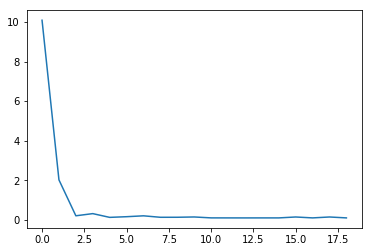

In [11]:
 _ = plt.plot(backfit.output_model_variation['e2'])

In [12]:
for values in backfit.output_model_dict.values():
    print(values.coef_())
    print(values.get_feature_names())

[-0.952]
['x2^0x4^0']
[-0.037 0.030 -0.018 1.007 -0.076 -0.042 0.005 -0.030 -0.061 0.031 -0.013 -0.003 0.005 0.449 -0.020 -0.007 -0.011 -0.006 0.002]
['x1^0', 'x2^0', 'x3^0', 'x1^2', 'x1^0x2^0', 'x1^0x3^0', 'x2^2', 'x2^0x3^0', 'x3^2', 'x1^3', 'x1^2x2^0', 'x1^2x3^0', 'x1^0x2^2', 'x1^0x2^0x3^0', 'x1^0x3^2', 'x2^3', 'x2^2x3^0', 'x2^0x3^2', 'x3^3']
[0.029]
['x1^0x5^0']
[-0.440]
['x3^0x4^0']
